# Generate synthetic data with the model from arxiv

$$\frac{dx_{i}(t)}{dt} = -\frac{x_{i}}{\tau} + \sum_{j=1}^{N} {w_{ij}\sigma(x_{j},\theta)}+u(t)$$


$$V_{k}^{E} = M_k\bar{x}(t)$$

$$\frac{V_{k}^{E}}{dt} = M_k \frac{d\bar{x}(t)}{dt}$$

$$\frac{dV^{E}_{k}}{dt} = - \frac{M_k}{\tau}\bar{x} + M_{k}\sum_{j=1}^{N} {w_{ij}\sigma(x_{j},\theta)}+M_{k}u(t)$$

## Forward Euler

$$ x_i(t+\Delta{t}) = x_i(t) + \Delta{t}[-\frac{x_{i}}{\tau} + \sum_{j=1}^{N} {w_{ij}\sigma(x_{j},\theta)}+u(t)]$$

## Prepare input stimuli with offtime analysis from bcipy and get the data

Nodes used for analysis: ['Fz', 'Cz', 'Pz', 'T5', 'O1', 'O2', 'T6']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prepare_data

In [2]:
inquiries, timings, labels = prepare_data.read_subject_data("/Users/aliag/Desktop/BciPy/bcipy/EEG_generation",[1,4,5])


In [4]:
total_stimulis = prepare_data.compute_stimuli(timings, labels)

In [5]:
len(total_stimulis[0][0])

396

In [21]:
timings = np.array(timings)
labels = np.array(labels)
stimuli_per_inquiry = []
stimuli_per_inquiry_2 = []

for i in range(100):
    stimuli = np.zeros(396*300)
    stimuli_2 = np.zeros(396)
    for j in range(10):
        if labels[i][j] == 1:
            stimuli[timings[i][j] * 300 : (timings[i][j] + 20) * 300] = 1
            stimuli_2[timings[i][j] : (timings[i][j] + 10)] = 1
        else:
            stimuli[timings[i][j] * 300 : (timings[i][j] + 10) * 300] = 0.5
            stimuli_2[timings[i][j]: (timings[i][j] + 10)] = 0.5
    stimuli_per_inquiry.append(stimuli)
    stimuli_per_inquiry_2.append(stimuli_2)


In [22]:
total_stimulis = []
for i in range(0,100):
    list=[]
    for j in range (0,3):
        list.append(stimuli_per_inquiry_2[i])
    total_stimulis.append(list)

In [23]:
total_stimulis = np.array(total_stimulis)
len(stimuli_per_inquiry)

100

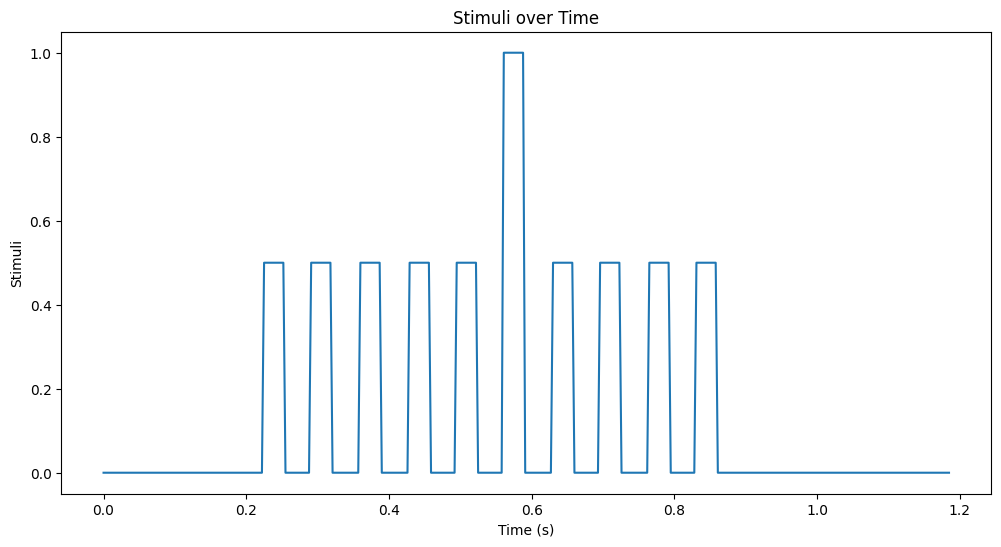

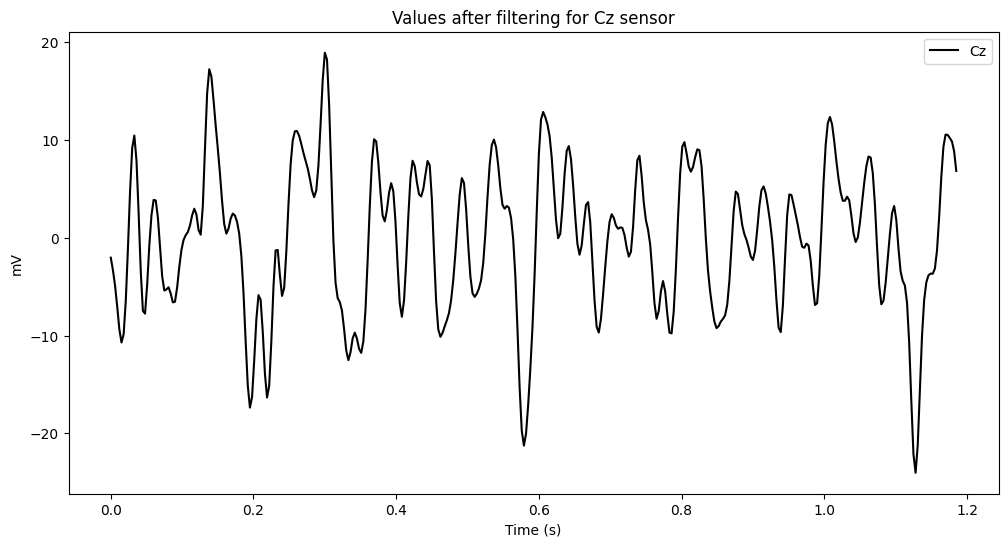

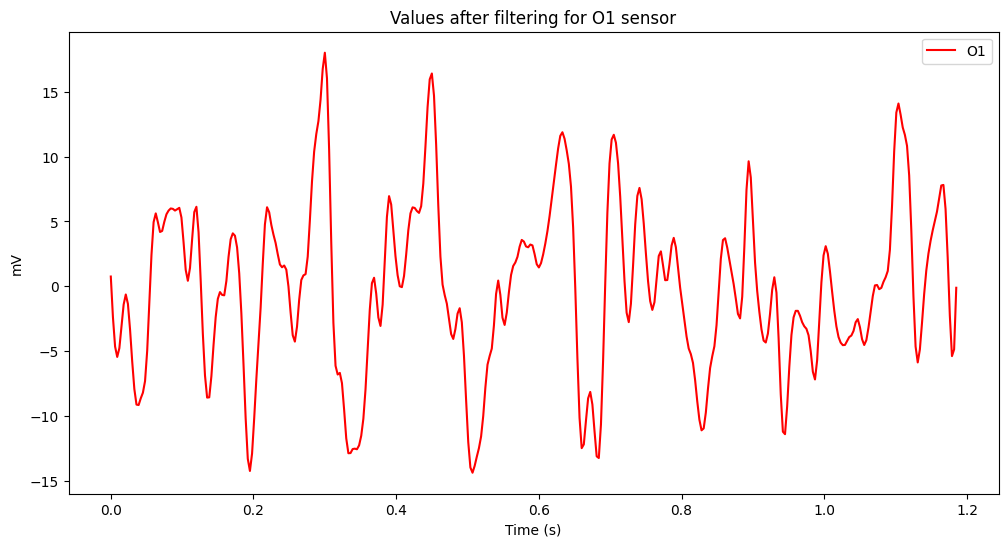

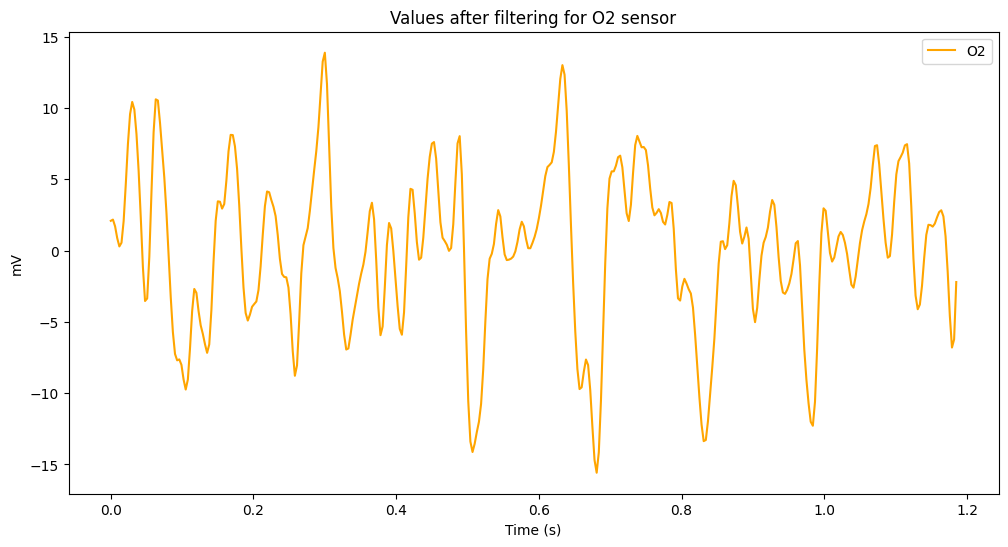

In [6]:
time = np.arange(0, 237600) / 100000
time_2 = np.arange(0,396)*300/100000

plt.figure(figsize=(12, 6))
plt.plot(time_2, total_stimulis[0][0])
plt.xlabel('Time (s)')
plt.ylabel('Stimuli')
plt.title('Stimuli over Time')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(time_2, inquiries[0][0], c = 'black',label='Cz')
#plt.plot(time_2, stimuli_2*20, label = 'stimuli')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.legend()
plt.title('Values after filtering for Cz sensor')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_2, inquiries[1][0], c='r', label='O1')
#plt.plot(time_2, stimuli_2*20, label = 'stimuli')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.legend()
plt.title('Values after filtering for O1 sensor')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(time_2, inquiries[2][0], c='orange', label='O2')
#plt.plot(time_2, stimuli_2*20, label = 'stimuli')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.legend()
plt.title('Values after filtering for O2 sensor')
plt.show()



# Compute membrane potentaials with neurolib

In [7]:
def membrane_potential_thersholded(rates_exc, rates_inh, synaptic_efficiency, kernel_size, threshold):
    #combined_signal = rates
    
    #combined_signal = np.ravel(rates * 0.05)
    combined_signal = (rates_exc-rates_inh)*synaptic_efficiency

    # Create a square kernel for convolution
    square_kernel = np.ones(kernel_size) / kernel_size # Normalize the kernel to maintain amplitude scale

    # Convolve the combined signal with the square kernel
    convolved_signal = np.convolve(combined_signal, square_kernel, mode='same')

    # Apply a threshold to the convolved signal
    thresholded_signal = np.where(convolved_signal < threshold, convolved_signal, 0.1)
    return convolved_signal

In [437]:
from neurolib.models.aln import ALNModel
model = ALNModel()
model.params['duration'] = 396
model.params['dt']=1
model.params["sigma_ou"] = 0.1
total_membrane_potentials = []
membrane_potentials = []
for stimuli in stimuli_per_inquiry_2:
    model.params["ext_exc_current"] = stimuli
    model.run()
    #membrane_potential = membrane_potential_thersholded(model["rates_exc"][0],model["rates_inh"][0],0.05,3,0)
    membrane_potential = model["rates_exc"][0]-model["rates_inh"][0]
    mn=[]
    for node in range(0,3):
        #membrane_potential[0:1000] = 0
        mn.append(membrane_potential)
    membrane_potentials.append(mn)
    total_membrane_potentials.append(membrane_potentials)
    


In [53]:
len(membrane_potentials[0][0])

792

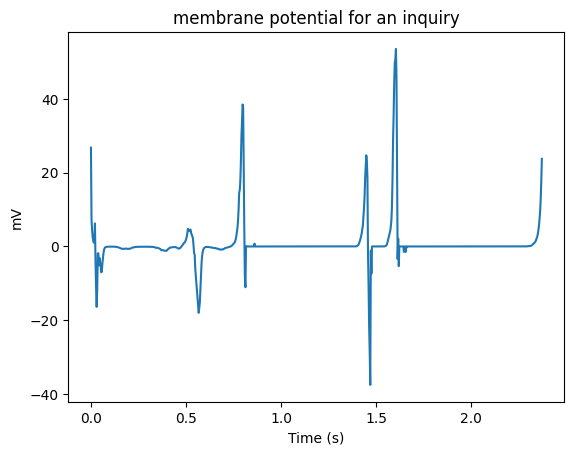

In [48]:
plt.plot(time_2, membrane_potentials[0])
#plt.plot(time, stimuli_per_inquiry[0]*80)
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title("membrane potential for an inquiry")
plt.show()

# Solve differential equations

In [7]:
import generate_synthetic_data as gd

In [8]:
tau = 10.0  # Time constant
theta = 1.0  # Sigmoid function parameter
neurons = 3
Cmat = np.random.randn(neurons, neurons)  # Weight matrix for model x
linear_model_weights = np.random.randn(neurons)  # Matrix M for model VE

# Initial conditions
x0 = -70e-3 * np.ones(neurons)
synthetic_membrane_potentials, synthetic_time_series_eeg = gd.generate_synthetic_data(tau, theta, Cmat, linear_model_weights, total_stimulis, x0)

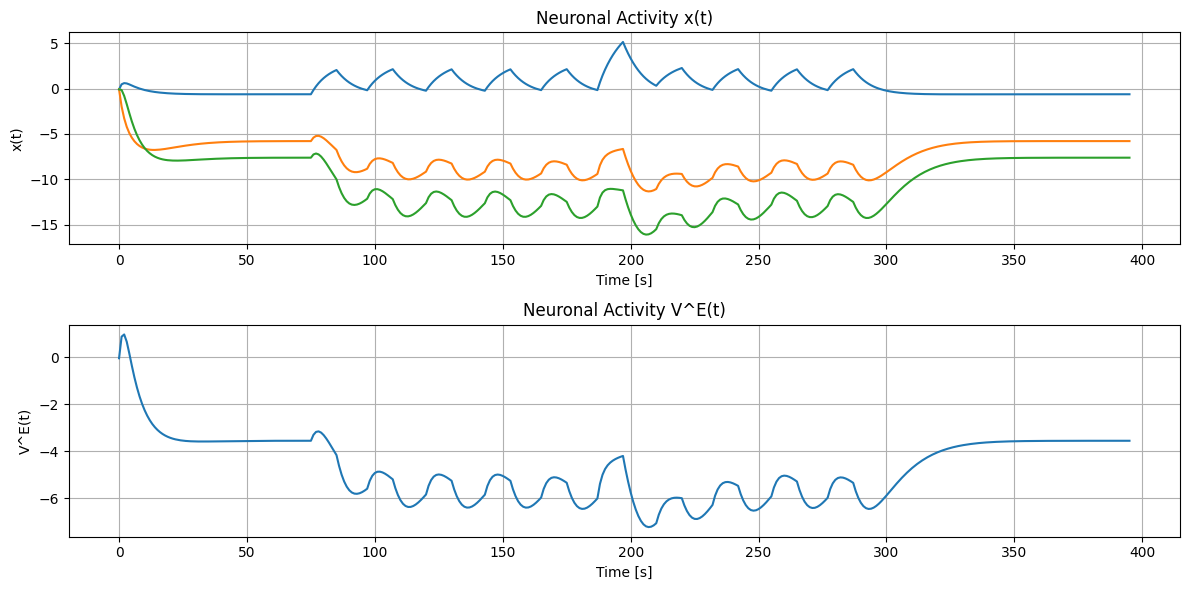

In [13]:
t = np.arange(0, 396)
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, synthetic_membrane_potentials[0])
plt.title('Neuronal Activity x(t)')
plt.xlabel('Time [s]')
plt.ylabel('x(t)')
plt.grid(True)

plt.subplot(212)
plt.plot(t, synthetic_time_series_eeg[0])
plt.title('Neuronal Activity V^E(t)')
plt.xlabel('Time [s]')
plt.ylabel('V^E(t)')
plt.grid(True)

plt.tight_layout()
plt.show()


# Trials for learning the weight matrix

In [527]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Define the sigmoid function
def sigma(x, theta):
    return 1 / (1 + np.exp(-theta * x))

# Define the first model differential equation
def model_x(x, t, tau, w, theta, u):
    dxdt = np.zeros_like(x)
    N = len(x)
    time_index = min(int(t), u.shape[1] - 1)  # Ensure index is within bounds
    for i in range(N):
        dxdt[i] = -x[i] / tau + np.sum(w[i, :] * sigma(x, theta)) + u[i, time_index]
    return dxdt

# Define the second model differential equation
def model_VE(VE, t, tau, M, w, theta, u):
    N = len(VE)
    x_bar = np.mean(VE)
    dVEdt = np.zeros_like(VE)
    time_index = min(int(t), u.shape[1] - 1)  # Ensure index is within bounds
    for k in range(N):
        dVEdt[k] = -M[k] * x_bar / tau + M[k] * np.sum(w[k, :] * sigma(VE, theta)) + M[k] * u[k, time_index]
    return dVEdt

# Set parameters
N = 3  # Number of neurons
tau = 10.0  # Time constant
theta = 1.0  # Sigmoid function parameter
w_true = np.random.randn(N, N)  # True weight matrix for generating synthetic data
M = np.random.randn(N)  # Matrix M for model VE

# Initial conditions
x0 = np.random.randn(N)
VE0 = np.random.randn(N)
input_signal = np.array(total_stimulis[0])  # Ensure this is your squared signal input of size (3, 792)

# Time vector
t = np.arange(0, 792)

# Generate synthetic data
synthetic_membrane_potentials = []
for _ in range(100):
    x = odeint(model_x, x0, t, args=(tau, w_true, theta, input_signal))
    synthetic_membrane_potentials.append(x)
print("Finished generating synthetic data")

# Convert synthetic data to numpy array and transpose to (100, 3, 792)
synthetic_membrane_potentials = np.array(synthetic_membrane_potentials).transpose(0, 2, 1)





Finished generating synthetic data


Finished generating synthetic data
Epoch [100/100], Loss: 0.5705
Learned connectivity matrix W:
 [[-1.4097514  -0.43002242  0.3524016 ]
 [-1.5185789  -0.76769197  1.4195617 ]
 [ 0.14130959 -0.01329377 -1.3504592 ]]
True connectivity matrix W:
 [[ 0.09831019 -0.052828   -1.42200652]
 [ 1.10506073 -0.8174009  -0.60956783]
 [-1.01331584  0.70118633 -1.52592972]]


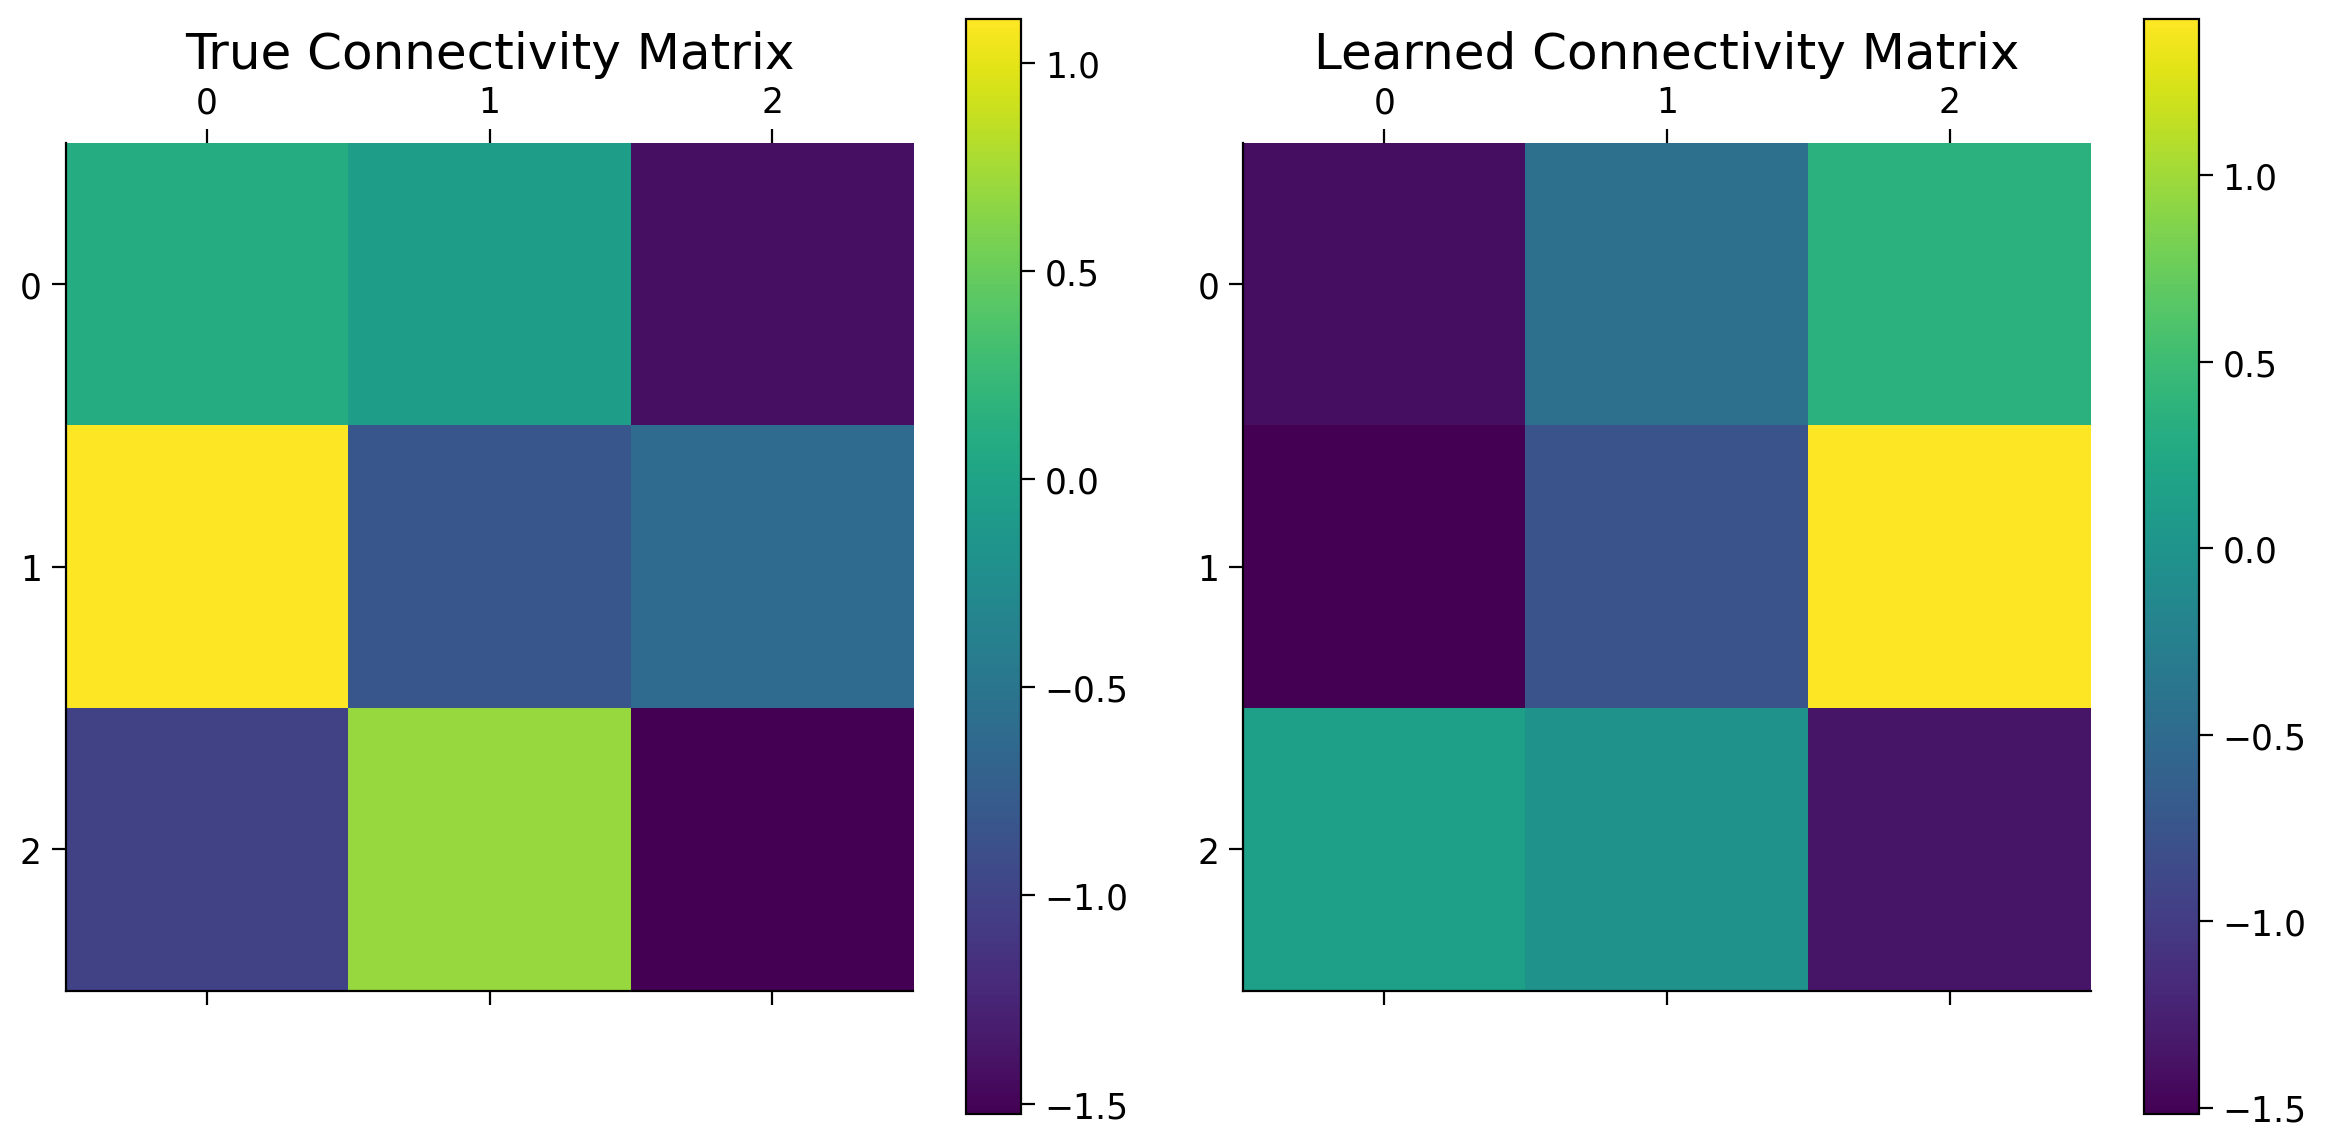

In [536]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Define the sigmoid function
def sigma(x, theta):
    return 1 / (1 + np.exp(-theta * x))

# Define the model differential equation for PyTorch
class ConnectivityModel(nn.Module):
    def __init__(self, N):
        super(ConnectivityModel, self).__init__()
        self.W = nn.Parameter(torch.randn(N, N))
        self.tau = 10.0
        self.theta = 1.0

    def forward(self, x, u):
        phi_x = 1 / (1 + torch.exp(-self.theta * x))
        dxdt = -x / self.tau + torch.matmul(phi_x, self.W.T) + u
        return dxdt

# Generate synthetic data
def generate_synthetic_data(w_true, input_signal, x0, t):
    def model_x(x, t, tau, w, theta, u):
        dxdt = np.zeros_like(x)
        N = len(x)
        time_index = min(int(t), len(u[0]) - 1)  # Ensure index is within bounds
        for i in range(N):
            dxdt[i] = -x[i] / tau + np.sum(w[i, :] * sigma(x, theta)) + u[i][time_index]
        return dxdt

    synthetic_data = []
    for _ in range(100):
        x = odeint(model_x, x0, t, args=(tau, w_true, theta, input_signal))
        synthetic_data.append(x)
    return np.array(synthetic_data)

# Set parameters
N = 3  # Number of neurons
tau = 10.0  # Time constant
theta = 1.0  # Sigmoid function parameter
w_true = np.random.randn(N, N)  # True weight matrix for generating synthetic data

# Initial conditions
x0 = np.random.randn(N)
input_signal = np.array(total_stimulis[0])  # Ensure this is your squared signal input of size (3, 792)

# Time vector
t = np.arange(0, 792)

# Generate synthetic data
synthetic_membrane_potentials = generate_synthetic_data(w_true, input_signal, x0, t)
print("Finished generating synthetic data")

# Convert synthetic data to numpy array and transpose to (100, 3, 792)
synthetic_membrane_potentials = np.array(synthetic_membrane_potentials).transpose(0, 2, 1)

# Convert data to PyTorch tensors
input_signal_torch = torch.tensor(input_signal, dtype=torch.float32)
synthetic_membrane_potentials_torch = torch.tensor(synthetic_membrane_potentials, dtype=torch.float32)

# Define the PyTorch model
model = ConnectivityModel(N)

# Define training parameters
learning_rate = 0.05
epochs = 100

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to solve the differential equation using PyTorch
def solve_differential_equation(model, x0, u, t):
    x_pred = [x0]
    x = x0
    for t_step in range(1, len(t)):
        u_t = u[:, t_step]
        dxdt = model(x, u_t)
        x = x + dxdt * (t[t_step] - t[t_step - 1])  # Using Euler's method for simplicity
        x_pred.append(x)
    return torch.stack(x_pred, dim=1)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    loss = 0
    for i in range(10):
        x0_sample = synthetic_membrane_potentials_torch[i, :, 0]
        u_sample = input_signal_torch
        t_sample = torch.tensor(t, dtype=torch.float32)
        
        x_pred = solve_differential_equation(model, x0_sample, u_sample, t_sample)
        loss += criterion(x_pred, synthetic_membrane_potentials_torch[i])
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Extract learned connectivity matrix
learned_W = model.W.detach().numpy()
print("Learned connectivity matrix W:\n", learned_W)
print("True connectivity matrix W:\n", w_true)

# Plotting the learned vs true connectivity matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
cax = axs[0].matshow(w_true, cmap='viridis')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('True Connectivity Matrix')

cax = axs[1].matshow(learned_W, cmap='viridis')
fig.colorbar(cax, ax=axs[1])
axs[1].set_title('Learned Connectivity Matrix')

plt.show()


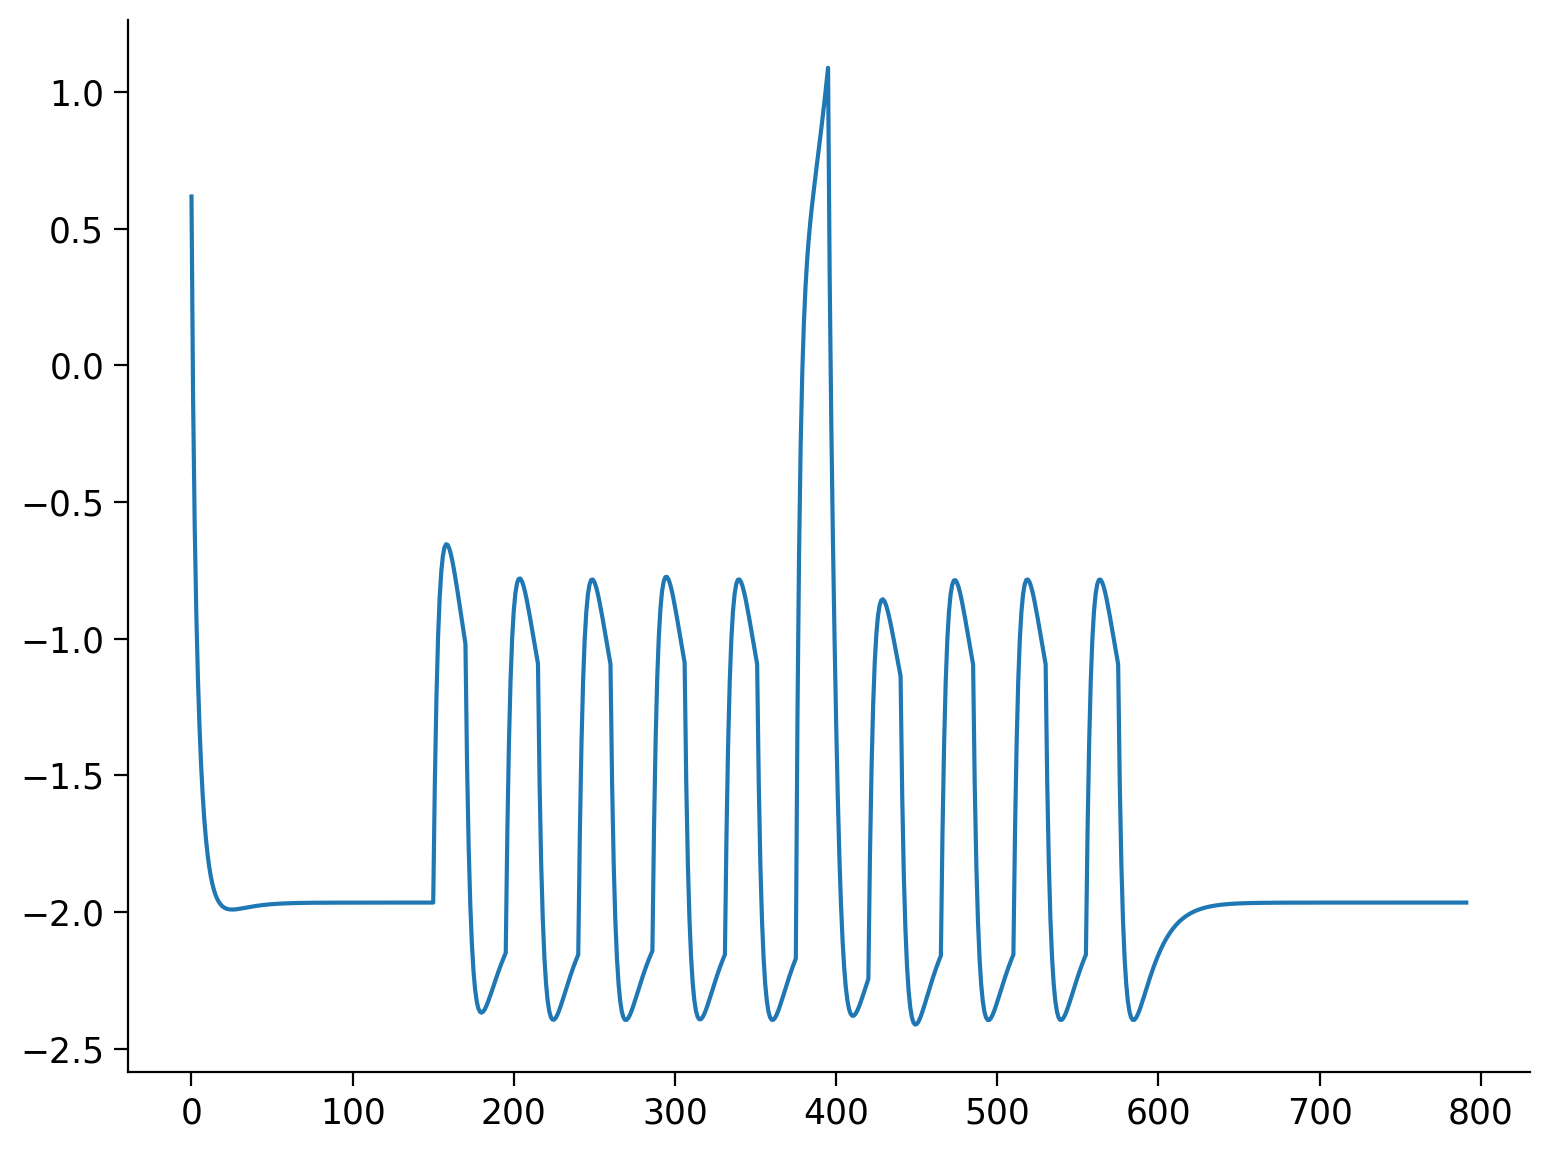

In [546]:
mb = odeint(model_x, x0, t, args=(tau, w_true, theta, input_signal))
mb = np.transpose(np.array(mb))
smp = np.transpose(np.array(synthetic_membrane_potentials))
plt.plot(synthetic_membrane_potentials[0][0])
plt.show()

# Model to transform membrane potential to EEG

## Prepare the data

In [20]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])
    
    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation and their labels."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    all_sets = []
    
    for index in fixation_indices:
        # Start from the next row after fixation and take the next 10 timestamps
        period = triggers.iloc[index + 1:index + 11]
        if not period.empty:
            initial_time = period['Time'].iloc[0]
            # Calculate relative times and labels for each event in the period
            relative_times = period['Time'].apply(lambda x: x - initial_time).tolist()
            labels = [1 if typ == 'target' else 0 for typ in period['Type']]
            all_sets.append([np.array(relative_times), np.array(labels)])
    
    return all_sets

trigger_files = [#'/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', 
                   '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt',
#                  '/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt'
                 
                 ]

# Initialize sets_of_data outside the loop to accumulate data from all files
sets_of_data = []

for trigger_file in trigger_files:
    triggers = read_triggers(trigger_file)
    sets_of_data.extend(extract_fixation_periods(triggers))  # Extend to accumulate across files

In [21]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])

    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    periods = []
    
    for index in fixation_indices:
        # Check if there are at least 10 entries after the fixation index
        end_index = index + 11
        if end_index > len(triggers):
            end_index = len(triggers)
        period = triggers.iloc[index + 1:end_index]
        if not period.empty:
            periods.append(period['Time'].tolist())
    
    return periods

import pandas as pd

def extract_data_from_intervals(raw_data_file, periods):
    """Extracts data rows corresponding to each period of timestamps and interpolates outliers."""
    raw_data_1 = pd.read_csv(raw_data_file, skiprows=2)
    raw_data = raw_data_1[20000:len(raw_data_1)-1]
    # Calculate 5th and 95th percentiles to determine outliers
    low_quantiles = raw_data.quantile(0)
    high_quantiles = raw_data.quantile(1)

    # Mask values that are outliers
    is_outlier = (raw_data < low_quantiles) | (raw_data > high_quantiles)
    filtered_data = raw_data.where(~is_outlier, other=pd.NA)

    # Interpolate missing values that were marked as outliers
    interpolated_data = filtered_data.interpolate(method='linear', limit_direction='both')
    print(len(interpolated_data))
    results = []
    relative_time=[]
    period_raw_data = []
    for period in periods:
        if period:
            # Get the start and end timestamps of the period
            start_time = period[0]
            end_time = period[-1]
            
            # Filter the data based on timestamps
            period_data = interpolated_data[(interpolated_data['lsl_timestamp'] >= start_time) & (interpolated_data['lsl_timestamp'] <= end_time)]
            period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
            # Calculate the average of certain columns, excluding some
            cols_to_avg = period_data.columns.difference(['lsl_timestamp', 'timestamp', 'relative_time', 'TRG', "X1","X2", "X3","A2","T3","T4","Fp1","Fp2","F7","F8","P3","P4","F3","F4","C3","C4"])
            period_data['average'] = period_data[cols_to_avg].mean(axis=1)
            period_raw_data.append(raw_data_1[(raw_data_1['lsl_timestamp'] >= start_time) & (raw_data_1['lsl_timestamp'] <= end_time)])
            relative_time.append(period_data['relative_time'])
            results.append(period_data[cols_to_avg])
    print(cols_to_avg)
    
    return results, interpolated_data, relative_time, period_raw_data, raw_data_1

# File pairs
file_pairs = [
     #('/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/raw_data.csv'),
     ('/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt', '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/raw_data_2.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/raw_data.csv')
]

filtered_raw_data=[]
filtered_data_sets = []
for trigger_file, raw_data_file in file_pairs:
    triggers = read_triggers(trigger_file)
    fixation_periods = extract_fixation_periods(triggers)
    results, filtered_data, relative_time, period_raw_data, raw_data=extract_data_from_intervals(raw_data_file, fixation_periods)
    filtered_data_sets.extend(results)
    filtered_raw_data.append(filtered_data)

295456


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['average'] = period_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:59: SettingWithCopyWarning: 
A value is

Index(['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6'], dtype='object')


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['average'] = period_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_28866/2516555487.py:62: SettingWithCopyWarning: 
A value is

In [22]:
values_Cz=[]
values_Fz=[]
values_O1=[]
values_O2=[]
values_Pz = []
values_T5 = []
valyes_T6 = []
square_signals=[]
rates=[]
rates_exc=[]
rates_inh=[]
synaptic_efficiency = 0.05  # Conversion from firing rate to synaptic current
kernel_size = 50  # Size of the square wave, represents the integration window in time steps
threshold = 0.5   # Threshold to highlight significant activity
times = []
model_output=[]
total_rates = []
square_signals_2=[]
final_values=[]
for i in range(0, len(filtered_data_sets)):
    if(len(filtered_data_sets[i]['O1'][0:396])==396):
        values = []
        values.append(np.array(filtered_data_sets[i]['Cz'][0:792]))
        values.append(np.array(filtered_data_sets[i]['O1'][0:792]))
        values.append(np.array(filtered_data_sets[i]['O2'][0:792]))
    final_values.append(values)

NameError: name 'values' is not defined

In [32]:
len(inquiries[0])

100

## Define the variables

In [108]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data
num_samples = 88
num_channels = 3
num_time_points = 396

#x_data = membrane_potentials[0:50]
x_data = synthetic_membrane_potentials
VE_data = inquiries

# Convert data to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32).reshape(100,3,396)
VE_data = torch.tensor(VE_data, dtype=torch.float32).reshape(100,3,396)
#VE_data = VE_data.permute(2, 0, 1)
print("x_data shape:", x_data.shape)
print("VE_data shape:", VE_data.shape)


x_data shape: torch.Size([100, 3, 396])
VE_data shape: torch.Size([100, 3, 396])


## Define the model

In [120]:
class MembranePotentialModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MembranePotentialModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2*hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2*hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Define model parameters
input_size = 396
hidden_size = 512
output_size = input_size

# Initialize the model, loss function, and optimizer
model = MembranePotentialModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Train the model

In [121]:
# Training parameters
num_epochs = 500
batch_size = 32

# Reshape data to fit the model
#x_data = x_data.view(num_samples, -1)
print(x_data.shape)
#VE_data = VE_data.view(num_samples, -1)
print(VE_data.shape)
# Training loop
for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Get batch data
        x_batch = x_data[i:i+batch_size]
        VE_batch = VE_data[i:i+batch_size]
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, VE_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Print loss for each epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


torch.Size([100, 3, 396])
torch.Size([100, 3, 396])
Epoch [10/500], Loss: 35.5642
Epoch [20/500], Loss: 35.5308
Epoch [30/500], Loss: 35.5249
Epoch [40/500], Loss: 35.5259
Epoch [50/500], Loss: 35.5268
Epoch [60/500], Loss: 35.5270
Epoch [70/500], Loss: 35.5274
Epoch [80/500], Loss: 35.5278
Epoch [90/500], Loss: 35.5280
Epoch [100/500], Loss: 35.5282
Epoch [110/500], Loss: 35.5283
Epoch [120/500], Loss: 35.5283
Epoch [130/500], Loss: 35.5284
Epoch [140/500], Loss: 35.5285
Epoch [150/500], Loss: 35.5286
Epoch [160/500], Loss: 35.5287
Epoch [170/500], Loss: 35.5288
Epoch [180/500], Loss: 35.5289
Epoch [190/500], Loss: 35.5289
Epoch [200/500], Loss: 35.5290
Epoch [210/500], Loss: 35.5288
Epoch [220/500], Loss: 35.5287
Epoch [230/500], Loss: 35.5288
Epoch [240/500], Loss: 35.5289
Epoch [250/500], Loss: 35.5289
Epoch [260/500], Loss: 35.5289
Epoch [270/500], Loss: 35.5290
Epoch [280/500], Loss: 35.5289
Epoch [290/500], Loss: 35.5293
Epoch [300/500], Loss: 35.5288
Epoch [310/500], Loss: 35.5

## Evaluation

Training Loss: 44.6178


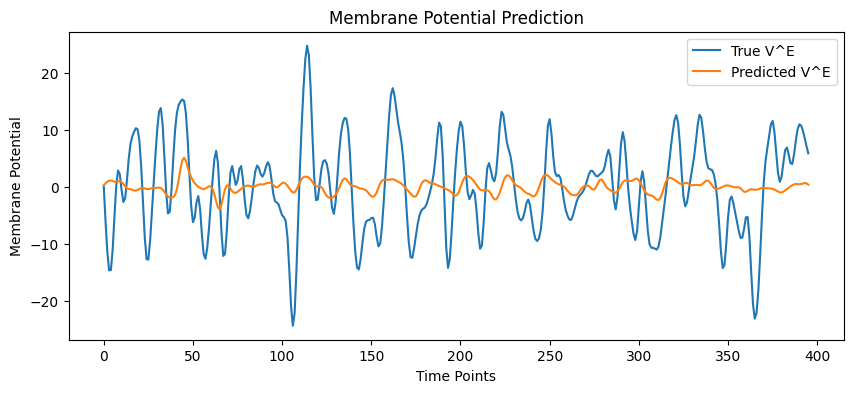

In [122]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Predict membrane potentials on the training data
    VE_pred = model(x_data)
    
    # Calculate the loss on the training data
    train_loss = criterion(VE_pred, VE_data)
    print(f'Training Loss: {train_loss.item():.4f}')

# Reshape VE_pred to the original size (num_samples, num_channels, num_time_points)
VE_data_r = VE_data.view(100, num_channels, num_time_points)
VE_pred_r = VE_pred.view(100, num_channels, num_time_points)

# Visualize some of the results
import matplotlib.pyplot as plt

# Select a sample to visualize
sample_idx = 2
plt.figure(figsize=(10, 4))
plt.plot(VE_data_r[sample_idx][0].numpy(), label='True V^E')
plt.plot(VE_pred_r[sample_idx][0].numpy(), label='Predicted V^E')
plt.legend()
plt.title('Membrane Potential Prediction')
plt.xlabel('Time Points')
plt.ylabel('Membrane Potential')
plt.show()



# Trials

In [ ]:
import sys
import os

# Add the directory containing the module to the Python path
module_path = os.path.abspath(os.path.join('..', '/Users/aliag/Desktop/BciPy/bcipy'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import the module
from signal.process import get_default_transform


Data shape: torch.Size([3, 39600])
Labels shape: torch.Size([3, 39600])
Epoch [10/500], Loss: 20.1716
Epoch [20/500], Loss: 17.1230
Epoch [30/500], Loss: 15.7057
Epoch [40/500], Loss: 15.0973
Epoch [50/500], Loss: 14.8760
Epoch [60/500], Loss: 14.7963
Epoch [70/500], Loss: 14.7671
Epoch [80/500], Loss: 14.7560
Epoch [90/500], Loss: 14.7526
Epoch [100/500], Loss: 14.7517
Epoch [110/500], Loss: 14.7514
Epoch [120/500], Loss: 14.7513
Epoch [130/500], Loss: 14.7513
Epoch [140/500], Loss: 14.7513
Epoch [150/500], Loss: 14.7513
Epoch [160/500], Loss: 14.7513
Epoch [170/500], Loss: 14.7513
Epoch [180/500], Loss: 14.7513
Epoch [190/500], Loss: 14.7513
Epoch [200/500], Loss: 14.7513
Epoch [210/500], Loss: 14.7513
Epoch [220/500], Loss: 14.7513
Epoch [230/500], Loss: 14.7513
Epoch [240/500], Loss: 14.7513
Epoch [250/500], Loss: 14.7513
Epoch [260/500], Loss: 14.7513
Epoch [270/500], Loss: 14.7513
Epoch [280/500], Loss: 14.7513
Epoch [290/500], Loss: 14.7513
Epoch [300/500], Loss: 14.7513
Epoch [

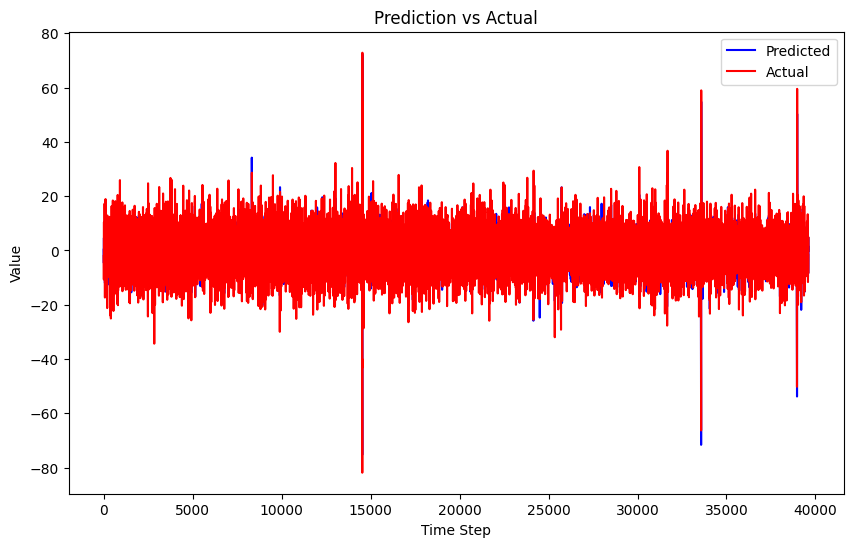

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Initialize hidden state
        out, _ = self.rnn(x, h0)  # Forward pass
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

# Parameters
input_size = 39600
hidden_size = 128
num_layers = 10
output_size = 39600
num_epochs = 500
batch_size = 16
learning_rate = 0.01

# Replace these with your actual data tensors
x_data = synthetic_membrane_potentials
VE_data = inquiries

# Convert data to PyTorch tensors and reshape
data = torch.tensor(x_data, dtype=torch.float32).reshape(3, -1)  # (3, 396 * 100)
labels = torch.tensor(VE_data, dtype=torch.float32).reshape(3, -1)  # (3, 396 * 100)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Prepare the dataset and DataLoader
dataset = TensorDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_data, batch_labels in dataloader:
        # Reshape batch_data and batch_labels to match the expected input shape for RNN
        batch_data = batch_data.unsqueeze(1)  # (batch_size, 1, input_size)
        batch_labels = batch_labels.unsqueeze(1)  # (batch_size, 1, output_size)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.squeeze(1))  # Adjusted for correct labels shape
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    total_loss = 0
    predictions = []
    actuals = []
    for batch_data, batch_labels in dataloader:
        # Reshape batch_data and batch_labels to match the expected input shape for RNN
        batch_data = batch_data.unsqueeze(1)  # (batch_size, 1, input_size)
        batch_labels = batch_labels.unsqueeze(1)  # (batch_size, 1, output_size)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.squeeze(1))  # Adjusted for correct labels shape
        total_loss += loss.item()
        predictions.append(outputs)
        actuals.append(batch_labels.squeeze(1))
    
    average_loss = total_loss / len(dataloader)
    print(f'Average Evaluation Loss: {average_loss:.4f}')

# Concatenate all predictions and actuals for plotting
predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()

# Plot the predictions vs the corresponding labels
plt.figure(figsize=(10, 6))
plt.plot(predictions[0], label='Predicted', color='b')
plt.plot(actuals[0], label='Actual', color='r')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()




In [134]:
len(total_stimulis[0][0])

396

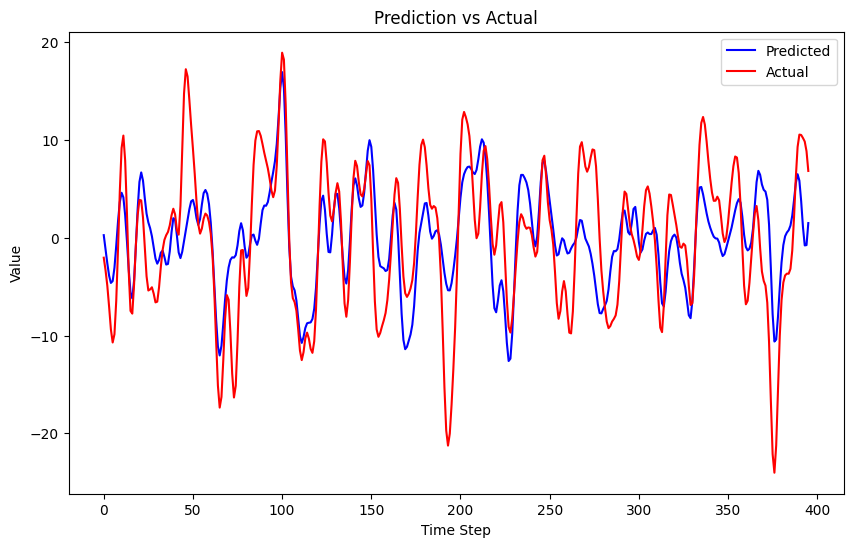

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(predictions[0][0:396], label='Predicted', color='b')
plt.plot(actuals[0][0:396], label='Actual', color='r')
#plt.plot(total_stimulis[0][0]*20)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()